In [1]:
import torch
from torchvision import datasets, transforms, models
import torchmetrics
import timm
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from PIL import Image
import requests
import os
print(torch.__version__)
CURRENT_PATH = os.getcwd()
print(CURRENT_PATH)

1.9.0
D:\MyCodes\Projects\YetiCTF\MNISTED - Not tested\dev


In [2]:
from libs import DefaultTrainer, DefaultGym

In [3]:
train_mean, train_std = 0.1307, 0.3081
BATCH_SIZE = 100
CLASSES = range(10)

train_loader = torch.utils.data.DataLoader(
  datasets.MNIST(f'{CURRENT_PATH}/dataset/mnist', train=True, download=True, transform = transforms.Compose([
                    transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[train_mean], std=[train_std]),
                    ])),
  batch_size=BATCH_SIZE, shuffle=True)

valid_loader = torch.utils.data.DataLoader(
  datasets.MNIST(f'{CURRENT_PATH}/dataset/mnist', train=False, download=True,
                             transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[train_mean], std=[train_std]),
                    ])),
  batch_size=BATCH_SIZE, shuffle=False)

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
print(f"train - {len(train_loader)} btchs | {len(train_loader.dataset)} imgs")
print(f"valid - {len(valid_loader)} btchs | {len(valid_loader.dataset)} imgs")

train - 600 btchs | 60000 imgs
valid - 100 btchs | 10000 imgs


tensor(-0.4242)
tensor(2.8215)
tensor(-0.0043)
tensor(0.9533)
8


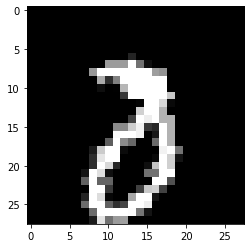

In [5]:
import matplotlib.pyplot as plt
# sanity check for training data
imgs, lbls = next(iter(train_loader))
imgs[7].data.shape
print(imgs.data.min())
print(imgs.data.max())
print(imgs.data.mean())
print(imgs.data.std())
print(CLASSES[lbls[0]])
plt.imshow(imgs[0].data.reshape((28,28)), cmap="gray");

tensor(-0.4242)
tensor(2.8215)
tensor(-0.0351)
tensor(0.9603)
7


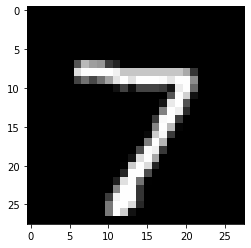

In [6]:
# sanity check for validation data
imgs, lbls = next(iter(valid_loader))
imgs[0].data.shape
print(imgs.data.min())
print(imgs.data.max())
print(imgs.data.mean())
print(imgs.data.std())
print(CLASSES[lbls[0]])
plt.imshow(imgs[0].data.reshape((28,28)), cmap="gray");

In [7]:
# CNN model definition
import torch.nn as nn
import torch.nn.functional as F

## deeper model adapted from https://www.kaggle.com/gustafsilva/cnn-digit-recognizer-pytorch
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128, 10)
        )
                
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [8]:
model = Model()

In [9]:
my_gym = DefaultGym(
    num_of_epochs=25,
    criterion=torch.nn.CrossEntropyLoss(),
    optimizer_wrap=lambda model: torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-1),
    scheduler_wrap=lambda optimizer: torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95),
    metrics=[torchmetrics.MetricCollection([
                torchmetrics.Precision(num_classes=10, average='macro'),
                torchmetrics.Recall(num_classes=10, average='macro')])] * 2,
    target_metric_key="Precision",
    log_dir="logs")

In [10]:
my_trainer = DefaultTrainer(dataloaders={"train": train_loader, "valid": valid_loader},
                            gyms=[my_gym])

In [11]:
trained = my_trainer.fit(model)


Initializing the training room(<class 'libs.DefaultGym'>) for the model(<class '__main__.Model'>)
    Options of gym:
        * criterion - <class 'torch.nn.modules.loss.CrossEntropyLoss'>;
        * optimizer - {'lr': 0.1, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False};
        * scheduler - {'step_size': 1, 'gamma': 0.95, 'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.1
    lr: 0.1
    weight_decay: 0
), 'base_lrs': [0.1], 'last_epoch': 0, '_step_count': 1, 'verbose': False, '_get_lr_called_within_step': False, '_last_lr': [0.1]};

        Metrics:
            train: MetricCollection(
  (Precision): Precision()
  (Recall): Recall()
)
            valid: MetricCollection(
  (Precision): Precision()
  (Recall): Recall()
)

    Dataloaders:
            train: shape - 600 btchs | 60000 imgs; transforms - ;
            valid: shape - 100 btchs | 10000 imgs; transforms - ;
                    


Epochs: 0epochs [00:00, ?epochs/s]

valid steps: 0steps [00:00, ?steps/s]

train steps: 0steps [00:00, ?steps/s]

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


The validation score(Precision) has improved from 0.0 to 0.979338526725769... Saving model.
The validation score(Precision) has improved from 0.979338526725769 to 0.9827855825424194... Saving model.
The validation score(Precision) has improved from 0.9827855825424194 to 0.9869351983070374... Saving model.
The validation score(Precision) has improved from 0.9869351983070374 to 0.9905048608779907... Saving model.
The validation score(Precision) has improved from 0.9905048608779907 to 0.9907800555229187... Saving model.
The validation score(Precision) has improved from 0.9907800555229187 to 0.9911941289901733... Saving model.
The validation score(Precision) has improved from 0.9911941289901733 to 0.992155909538269... Saving model.
The validation score(Precision) has improved from 0.992155909538269 to 0.9928884506225586... Saving model.
The validation score(Precision) has improved from 0.9928884506225586 to 0.994999885559082... Saving model.
The validation score(Precision) has improved fro

In [22]:
torch.jit.save(torch.jit.script(model), 'anal-model-jit-script.pth')